In [ ]:
### Cosmology and astropy packages
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table

### Arrays, tables, plots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import multivariate_normal

### SLSim functions
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate
from slsim.Lenses.lens_pop import LensPop
from slsim.Util.param_util import ellipticity2phi_q, amplitude_to_magnitude
from slsim.Util.distribution_plot_utils.py import make_contour
from slsim.ImageSimulation.image_simulation import (
    point_source_coordinate_properties,
    lens_image_series,
    rgb_image_from_image_list,
    create_image_montage_from_image_list,
)
from slsim.LsstSciencePipeline.rubin_sim_pipeline import get_rubin_cadence

### Readin, readout, paths
import io
import os
import json
from contextlib import redirect_stdout
from tqdm import tqdm
from PIL import Image

### import required lenstronomy functions
from lenstronomy.Util.data_util import bkg_noise

### recompile packages after each edit
%load_ext autoreload
%autoreload 2

In [2]:
# Compute absolute magnitude from apparent magnitude and redshift
# no k-corrections added here
def compute_absolute_magnitude(apparent_mag, redshift, cosmo):
    luminosity_distance = cosmo.luminosity_distance(redshift).to(u.pc).value
    absolute_mag = apparent_mag - 5 * (np.log10(luminosity_distance) - 1)
    return absolute_mag


def compute_apparent_magnitude(absolute_mag, redshift, cosmo):
    luminosity_distance = cosmo.luminosity_distance(redshift).to(u.pc).value
    apparent_mag = absolute_mag + 5 * (np.log10(luminosity_distance) - 1)
    return apparent_mag

# Lensed quasar population

In this notebook, we generate lensed quasar population using different methods and analyse the color distribution of deflectors and quasars.

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
galaxy_sky_area = Quantity(
    value=10, unit="deg2"
)  # this is the sky area over which galaxies are sampled
quasar_sky_area = Quantity(value=10, unit="deg2")
full_sky_area = Quantity(value=1000, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 5.0}

In [4]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=["u", "g", "r", "i", "z", "y"],
    cosmo=cosmo,
    z_min=0,
    z_max=4,
)

In [5]:
### here we generate deflectors
# lens_galaxies_all = deflectors.AllLensGalaxies(
#     red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
#     blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
#     kwargs_cut=kwargs_deflector_cut,
#     kwargs_mass2light={},
#     cosmo=cosmo,
#     gamma_pl={"mean": 2, "std_dev": 0.16},
#     sky_area=galaxy_sky_area,
# )

lens_galaxies_ell = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
    gamma_pl=dict(mean=2.0, std_dev=0.16),
)

In [6]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)

In [ ]:
# quasar sample with host galaxy
quasar_source_plus_galaxy = quasar_class.quasar_sample(
    m_min=15, m_max=28, host_galaxy=True
)

In [ ]:
len(quasar_source_plus_galaxy[quasar_source_plus_galaxy["z"] > 4]) / len(
    quasar_source_plus_galaxy
)

In [ ]:
plt.hist(quasar_source_plus_galaxy["z"])

### Define variable quasars and quasar host galaxies

In [10]:
# Prepare dictionary of agn variability kwargs
length_of_light_curve = 3850
variable_agn_kwarg_dict = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": 1,
    # "log_breakpoint_frequency": 1 / 20,
    # "low_frequency_slope": 1,
    # "high_frequency_slope": 3,
    # "standard_deviation": 0.9,
}
# variable_agn_kwarg_dict = {}
kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "u", "g", "r", "i", "z", "y"},
    "agn_driving_variability_model": "bending_power_law_from_distribution",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, length_of_light_curve, 1),
    "corona_height": 10,
    "r_resolution": 500,
}

kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "u", "g", "r", "i", "z", "y"},
    "agn_driving_variability_model": "bending_power_law",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, length_of_light_curve, length_of_light_curve),
    "r_resolution": 500,
    "corona_height": 10,
}
# Initiate source population class.
source_quasar_plus_galaxies = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source_plus_galaxy,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    catalog_type="skypy",
    point_source_type="quasar",
    extended_source_type="single_sersic",
    point_source_kwargs=kwargs_quasar,
)

In [ ]:
quasar_source_plus_galaxy.columns

### Make the quasar lens population object

In [12]:
# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop_ell = LensPop(
    deflector_population=lens_galaxies_ell,
    source_population=source_quasar_plus_galaxies,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

## Draw lenses

In [ ]:
### LSST cuts: 'u': 23.9,'g':25.0, 'r':24.7, 'i':24.0, 'z':23.3, 'y':22.1
kwargs_lens_cuts = {
    "min_image_separation": 0.7,
    "max_image_separation": 10,
    "second_brightest_image_cut": {"i": 23.3},
}
# drawing population
# the key difference in lens population drawing time is whether you ask for magnitude cuts or not I think?
quasar_lens_population = quasar_lens_pop_ell.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

In [15]:
# ### LSST cuts: 'u': 23.9,'g':25.0, 'r':24.7, 'i':24.0, 'z':23.3, 'y':22.1
# kwargs_lens_cuts = {
#     "min_image_separation": 0.7,
#     "max_image_separation": 10,
#     "second_brightest_image_cut": {"g": 25.0},
# }
# # drawing population
# # the key difference in lens population drawing time is whether you ask for magnitude cuts or not I think?
# # when you use all deflectors to generate a population WITH CUTS,
# quasar_lens_population_all_deflector = quasar_lens_pop_all.draw_population(
#     speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
# )

In [ ]:
# ### LSST cuts: 'u': 23.9,'g':25.0, 'r':24.7, 'i':24.0, 'z':23.3, 'y':22.1
# kwargs_lens_cuts2 = {
#     "min_image_separation": 0.7,
#     "max_image_separation": 10,
#     "second_brightest_image_cut": {"g": 25.0},
# }
# # drawing population
# # the key difference in lens population drawing time is whether you ask for magnitude cuts or not I think?
# quasar_lens_population2 = quasar_lens_pop_ell.draw_population(
#     speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts2
# )

### View associated catalog

In [ ]:
f = io.StringIO()
full_pop_df = pd.DataFrame()
with redirect_stdout(f):
    for i, lens_obj in enumerate(quasar_lens_population):
        full_pop_df = lens_obj.lens_to_dataframe(index=i, df=full_pop_df)
        for band in ["u", "g", "r", "i", "z", "y"]:
            full_pop_df.loc[i, f"ps_{band}_mag_true"] = lens_obj.point_source_magnitude(
                band=band, lensed=False
            )
        image2mag = full_pop_df.loc[i, "point_source_light_i_magnitude_1"]
        try:
            image3mag = full_pop_df.loc[i, "point_source_light_i_magnitude_2"]
        except KeyError:
            image3mag = 0
        second_or_third_mag = (
            image3mag if not (np.isnan(image3mag) or image3mag == 0) else image2mag
        )
        full_pop_df.loc[i, "i3"] = second_or_third_mag
        (
            full_pop_df.loc[i, "deflector_mass_phi"],
            full_pop_df.loc[i, "deflector_mass_q"],
        ) = ellipticity2phi_q(
            full_pop_df.loc[i, "deflector_mass_e1"],
            full_pop_df.loc[i, "deflector_mass_e2"],
        )
        (
            full_pop_df.loc[i, "deflector_light_phi"],
            full_pop_df.loc[i, "deflector_light_q"],
        ) = ellipticity2phi_q(
            full_pop_df.loc[i, "deflector_light_i_e1"],
            full_pop_df.loc[i, "deflector_light_i_e2"],
        )
        full_pop_df.loc[i, "deflector_stellar_mass"] = lens_obj.deflector_stellar_mass()
        full_pop_df.loc[i, "lens_obj"] = lens_obj

In [ ]:
_, bins, _ = plt.hist(
    quasar_source_plus_galaxy["z"], density=True, bins=np.arange(0, 5, 0.2)
)
plt.hist(full_pop_df["point_source_redshift"], density=True, bins=bins);

In [ ]:
# f = io.StringIO()
# full_pop_df_all = pd.DataFrame()
# with redirect_stdout(f):
#     for i, lens_obj in tqdm(
#         enumerate(quasar_lens_population_all_deflector),
#         total=len(quasar_lens_population_all_deflector),
#     ):
#         full_pop_df_all = lens_obj.lens_to_dataframe(index=i, df=full_pop_df_all)
#         for band in ["u", "g", "r", "i", "z", "y"]:
#             full_pop_df_all.loc[i, f"ps_{band}_mag_true"] = (
#                 lens_obj.point_source_magnitude(band=band, lensed=False)
#             )
#             image2mag = full_pop_df_all.loc[i, "point_source_light_i_magnitude_1"]
#             image3mag = full_pop_df_all.loc[i, "point_source_light_i_magnitude_2"]
#             second_or_third_mag = (
#                 image3mag if not (np.isnan(image3mag) or image3mag == 0) else image2mag
#             )

#         (
#             full_pop_df_all.loc[i, "deflector_mass_phi"],
#             full_pop_df_all.loc[i, "deflector_mass_q"],
#         ) = ellipticity2phi_q(
#             full_pop_df_all.loc[i, "deflector_mass_e1"],
#             full_pop_df_all.loc[i, "deflector_mass_e2"],
#         )
#         (
#             full_pop_df_all.loc[i, "deflector_light_phi"],
#             full_pop_df_all.loc[i, "deflector_light_q"],
#         ) = ellipticity2phi_q(
#             full_pop_df_all.loc[i, "deflector_light_i_e1"],
#             full_pop_df_all.loc[i, "deflector_light_i_e2"],
#         )
#         full_pop_df_all.loc[i, "deflector_stellar_mass"] = (
#             lens_obj.deflector_stellar_mass()
#         )
#         full_pop_df_all.loc[i, "lens_obj"] = lens_obj

In [ ]:
# f = io.StringIO()
# full_pop_df2 = pd.DataFrame()
# with redirect_stdout(f):
#     for i, lens_obj in enumerate(quasar_lens_population2):
#         full_pop_df2 = lens_obj.lens_to_dataframe(index=i, df=full_pop_df2)
#         for band in ["u", "g", "r", "i", "z", "y"]:
#             full_pop_df2.loc[i, f"ps_{band}_mag_true"] = (
#                 lens_obj.point_source_magnitude(band=band, lensed=False)
#             )
#             # lensed_mags = lens_obj.point_source_magnitude(band=band, lensed=True)
#             # for i in range(len(lensed_mags))
#             #     full_pop_df2.loc[i, f"ps_{band}_mag_true_lensed"] = lens_obj.point_source_magnitude(band=band, lensed=True)
#         full_pop_df2.loc[i, "lens_obj"] = lens_obj

In [ ]:
full_pop_df.to_pickle("dec05_500sqdeg_g25_i07.pkl")
# full_pop_df_all.to_pickle("dec05_500sqdeg_alldeflectors_g25_i07.pkl")

## View deflector galaxy colors

### Load in PanSTARRS colors from SLED -- not necessarily deblended colors

In [ ]:
### load in sled data
# Load JSON
with open("../../../slsim_gal_verification.json", "r") as file:
    slsim_gal_verification = json.load(file)

with open("../../../slsim_gal_verification1.json", "r") as file:
    slsim_gal_verification1 = json.load(file)

with open("../../../slsim_gal_verification2.json", "r") as file:
    slsim_gal_verification2 = json.load(file)

with open("../../../slsim_gal_verification3.json", "r") as file:
    slsim_gal_verification3 = json.load(file)

# Combine all data into a single dataframe
slsim_gal_verification_combined = (
    slsim_gal_verification
    + slsim_gal_verification1
    + slsim_gal_verification2
    + slsim_gal_verification3
)
sled_df = pd.DataFrame(slsim_gal_verification_combined)


def expand_catalogue(cat_list):
    out = {}
    for entry in cat_list:
        inst = entry.get("instrument", "").replace(" ", "_")
        band = entry.get("band", "")

        # build column names
        mag_col = f"{inst}_mag_{band}"
        dmag_col = f"{inst}_Dmag_{band}"
        dist_col = f"{inst}_distance_{band}"

        # extract values safely
        mag = entry.get("mag")
        dmag = entry.get("Dmag")
        dist = entry.get("distance")

        # convert to float only if non-null, else NaN
        out[mag_col] = float(mag) if mag not in [None, ""] else np.nan
        out[dmag_col] = float(dmag) if dmag not in [None, ""] else np.nan
        out[dist_col] = float(dist) if dist not in [None, ""] else np.nan

    return out


# Apply to all rows
expanded = sled_df["catalogue"].apply(expand_catalogue).apply(pd.Series)

# Combine with main dataframe
sled_df = pd.concat([sled_df.drop(columns=["catalogue"]), expanded], axis=1)

### Compare SLSim Deflector colors to the PanSTARRS colors (generated using elliptical lensing galaxies and elliptical + spiral lensing galaxies)

In [ ]:
bands = list("ugrizy")
wanted = full_pop_df[[f"deflector_light_{b}_magnitude" for b in bands[1:]]]
# Calculate the colors for deflectors
deflector_colors = pd.DataFrame(
    {
        "g-r": full_pop_df["deflector_light_g_magnitude"]
        - full_pop_df["deflector_light_r_magnitude"],
        "r-i": full_pop_df["deflector_light_r_magnitude"]
        - full_pop_df["deflector_light_i_magnitude"],
        "i-z": full_pop_df["deflector_light_i_magnitude"]
        - full_pop_df["deflector_light_z_magnitude"],
        "z-y": full_pop_df["deflector_light_z_magnitude"]
        - full_pop_df["deflector_light_y_magnitude"],
    }
)

# deflector_colors_all = pd.DataFrame(
#     {
#         "g-r": full_pop_df_all["deflector_light_g_magnitude"]
#         - full_pop_df_all["deflector_light_r_magnitude"],
#         "r-i": full_pop_df_all["deflector_light_r_magnitude"]
#         - full_pop_df_all["deflector_light_i_magnitude"],
#         "i-z": full_pop_df_all["deflector_light_i_magnitude"]
#         - full_pop_df_all["deflector_light_z_magnitude"],
#         "z-y": full_pop_df_all["deflector_light_z_magnitude"]
#         - full_pop_df_all["deflector_light_y_magnitude"],
#     }
# )

# Calculate the colors for deflectors in sled_df using Pan-STARRS1 magnitudes
sled_deflector_colors = pd.DataFrame(
    {
        "g-r": sled_df["Pan-STARRS1_mag_g"] - sled_df["Pan-STARRS1_mag_r"],
        "r-i": sled_df["Pan-STARRS1_mag_r"] - sled_df["Pan-STARRS1_mag_i"],
        "i-z": sled_df["Pan-STARRS1_mag_i"] - sled_df["Pan-STARRS1_mag_z"],
        "z-Y": sled_df["Pan-STARRS1_mag_z"] - sled_df["Pan-STARRS1_mag_Y"],
    }
).dropna()
# Generate the corner plot
fig = make_contour(
    [
        deflector_colors,
        sled_deflector_colors,
    ],  # deflector_colors_all, sled_deflector_colors],
    labels=["g-r", "r-i", "i-z", "z-y"],
    colors=["b", "r"],  # , "orange"],
    categories=[
        "Lenses generated using elliptical \ngalaxies",
        # "Lenses generated using\n all galaxies",
        "SLED deflectors: Pan-STARRS1",
    ],
    show_every_title=True,
)
fig.suptitle("Deflector Colors in SLSim", y=1.04, size=40)

PanSTARRS colors probably look bluer because the arc light from the AGN host galaxy is blended in.

### Run the cell below if you want to compare population generated with and without magnitude cuts
Note that ultimately, the time-consuming part is computing other bands magnitudes; the output should look like something below:

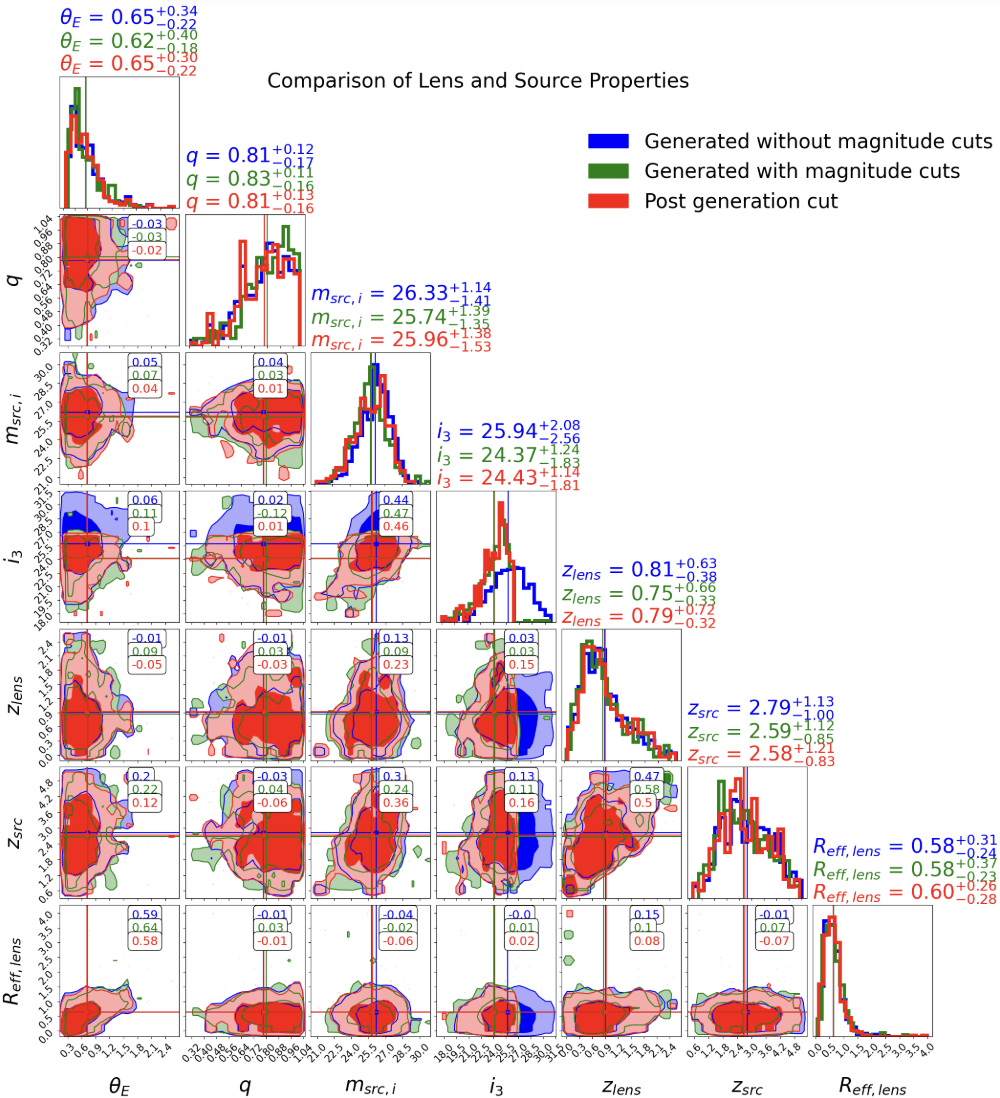

In [ ]:
# 1  # Define the columns to compare
# columns_to_compare = [
#     "deflector_mass_theta_E",  # Einstein radius
#     "deflector_mass_q",  # Ellipticity
#     "extended_source_i_mag",  # Extended source magnitude
#     "i3",  # 2nd/3rd i-band point source lensed magnitude
#     "deflector_redshift",  # Lens redshift
#     "point_source_redshift",  # Source redshift
#     "deflector_light_i_R_sersic",  # Lens effective radius
# ]

# # Extract the relevant columns from both dataframes
# data_full_pop_df = full_pop_df[columns_to_compare].dropna()
# data_full_pop_df2 = full_pop_df2[columns_to_compare].dropna()
# data_post_trunc = full_pop_df[full_pop_df["g3"] < 25][columns_to_compare].dropna()

# # Create the contour plot
# fig = make_contour(
#     list_of_dists=[data_full_pop_df, data_full_pop_df2, data_post_trunc],
#     labels=[
#         r"$\theta_E$",
#         r"$q$",
#         r"$m_{src,i}$",
#         r"$i_{3}$",
#         r"$z_{lens}$",
#         r"$z_{src}$",
#         r"$R_{eff,lens}$",
#     ],
#     categories=[
#         "Generated without magnitude cuts",
#         "Generated with magnitude cuts",
#         "Post generation cut",
#     ],
#     colors=["blue", "green", "red"],
#     show_every_title=True,
# )

# fig.suptitle("Comparison of Lens and Source Properties", size=30)

### Compare deflector color against redhsift, ellipticity, gamma_pl

#### We also want to compare against absolute mag, so adding that to the dataframe:

In [ ]:
# Convert the deflector_table to a DataFrame for easier manipulation
lens_galaxies_df = lens_galaxies_ell.deflector_table[["M", "stellar_mass"]].to_pandas()

# Merge full_pop_df with lens_galaxies_df on the stellar mass columns
matched_lenses_ell = full_pop_df.merge(
    lens_galaxies_df[["stellar_mass", "M"]],
    left_on="deflector_stellar_mass",
    right_on="stellar_mass",
    how="inner",
)
matched_absolute_mags_ell = matched_lenses_ell[["deflector_stellar_mass", "M"]]

# lens_galaxies_df = lens_galaxies_all.deflector_table[['M', 'stellar_mass']].to_pandas()

# # Merge full_pop_df with lens_galaxies_df on the stellar mass columns
# matched_lenses_all = full_pop_df_all.merge(
#     lens_galaxies_df[['stellar_mass', 'M']],
#     left_on='deflector_stellar_mass',
#     right_on='stellar_mass',
#     how='inner'
# )
# matched_absolute_mags_all = matched_lenses_all[['deflector_stellar_mass', 'M']]

In [ ]:
# Calculate the colors for deflectors
deflector_colors = pd.DataFrame(
    {
        "g-r": full_pop_df["deflector_light_g_magnitude"]
        - full_pop_df["deflector_light_r_magnitude"],
        "r-i": full_pop_df["deflector_light_r_magnitude"]
        - full_pop_df["deflector_light_i_magnitude"],
        "i-z": full_pop_df["deflector_light_i_magnitude"]
        - full_pop_df["deflector_light_z_magnitude"],
        "z-y": full_pop_df["deflector_light_z_magnitude"]
        - full_pop_df["deflector_light_y_magnitude"],
    }
)

# deflector_colors_all = pd.DataFrame(
#     {
#         "g-r": full_pop_df_all["deflector_light_g_magnitude"]
#         - full_pop_df_all["deflector_light_r_magnitude"],
#         "r-i": full_pop_df_all["deflector_light_r_magnitude"]
#         - full_pop_df_all["deflector_light_i_magnitude"],
#         "i-z": full_pop_df_all["deflector_light_i_magnitude"]
#         - full_pop_df_all["deflector_light_z_magnitude"],
#         "z-y": full_pop_df_all["deflector_light_z_magnitude"]
#         - full_pop_df_all["deflector_light_y_magnitude"],
#     }
# )

deflector_colors["gamma_pl"] = full_pop_df["deflector_mass_gamma"]
deflector_colors["mass_q"] = full_pop_df["deflector_mass_q"]
deflector_colors["light_q"] = full_pop_df["deflector_light_q"]
deflector_colors["redshift"] = full_pop_df["deflector_redshift"]
deflector_colors["stellar_mass"] = np.log10(full_pop_df["deflector_stellar_mass"])
deflector_colors["M_i"] = matched_lenses_ell["M"]

# deflector_colors_all["gamma_pl"] = full_pop_df_all["deflector_mass_gamma"]
# deflector_colors_all["mass_q"] = full_pop_df_all["deflector_mass_q"]
# deflector_colors_all["light_q"] = full_pop_df_all["deflector_light_q"]
# deflector_colors_all["redshift"] = full_pop_df_all["deflector_redshift"]
# deflector_colors_all["stellar_mass"] = np.log10(
#     full_pop_df_all["deflector_stellar_mass"]
# )
# deflector_colors_all["M_i"] = matched_lenses_all["M"]

fig = make_contour(
    [deflector_colors],  # , deflector_colors_all],
    labels=[
        "g-r",
        "r-i",
        "i-z",
        "z-y",
        "$\gamma_{lens}$",
        "$q_{m}$",
        "$q_l$",
        "$z_{lens}$",
        "$\log(M_*/M_{\\odot})$",
        "$M_i$",
    ],
    categories=["EllipticalLensGalaxies"],  # , "AllLensGalaxies"],
    colors=["red"],  # , "blue"],
    show_every_title=True,
)
for ax in fig.axes[:: len(deflector_colors.columns)]:
    ax.axvline(x=0.6, color="black", linestyle="--", linewidth=4)

### Load in HSC data

In [ ]:
hsc_data = pd.read_csv("../../../../../Downloads/864515.csv")

In [ ]:
full_pop_df["deflector_light_g_magnitude"]

In [ ]:
hsc_data_filtered = hsc_data[
    (hsc_data["g_cmodel_mag"] >= full_pop_df["deflector_light_g_magnitude"].min())
    & (hsc_data["g_cmodel_mag"] <= full_pop_df["deflector_light_g_magnitude"].max())
    & (hsc_data["r_cmodel_mag"] >= full_pop_df["deflector_light_r_magnitude"].min())
    & (hsc_data["r_cmodel_mag"] <= full_pop_df["deflector_light_r_magnitude"].max())
    & (hsc_data["i_cmodel_mag"] >= full_pop_df["deflector_light_i_magnitude"].min())
    & (hsc_data["i_cmodel_mag"] <= full_pop_df["deflector_light_i_magnitude"].max())
].dropna()
hsc_data_filtered = hsc_data_filtered[np.isfinite(hsc_data_filtered).all(axis=1)]

In [ ]:
# Calculate the colors for deflectors
deflector_colors = pd.DataFrame(
    {
        "g-r": full_pop_df["deflector_light_g_magnitude"]
        - full_pop_df["deflector_light_r_magnitude"],
        "r-i": full_pop_df["deflector_light_r_magnitude"]
        - full_pop_df["deflector_light_i_magnitude"],
        "i-z": full_pop_df["deflector_light_i_magnitude"]
        - full_pop_df["deflector_light_z_magnitude"],
        "z-y": full_pop_df["deflector_light_z_magnitude"]
        - full_pop_df["deflector_light_y_magnitude"],
    }
)

# deflector_colors_all = pd.DataFrame(
#     {
#         "g-r": full_pop_df_all["deflector_light_g_magnitude"]
#         - full_pop_df_all["deflector_light_r_magnitude"],
#         "r-i": full_pop_df_all["deflector_light_r_magnitude"]
#         - full_pop_df_all["deflector_light_i_magnitude"],
#         "i-z": full_pop_df_all["deflector_light_i_magnitude"]
#         - full_pop_df_all["deflector_light_z_magnitude"],
#         "z-y": full_pop_df_all["deflector_light_z_magnitude"]
#         - full_pop_df_all["deflector_light_y_magnitude"],
#     }
# )

deflector_colors["gamma_pl"] = full_pop_df["deflector_mass_gamma"]
deflector_colors["mass_q"] = full_pop_df["deflector_mass_q"]
deflector_colors["light_q"] = full_pop_df["deflector_light_q"]
deflector_colors["redshift"] = full_pop_df["deflector_redshift"]
deflector_colors["stellar_mass"] = np.log10(full_pop_df["deflector_stellar_mass"])
deflector_colors["M_i"] = matched_lenses_ell["M"]

# deflector_colors_all["gamma_pl"] = full_pop_df_all["deflector_mass_gamma"]
# deflector_colors_all["mass_q"] = full_pop_df_all["deflector_mass_q"]
# deflector_colors_all["light_q"] = full_pop_df_all["deflector_light_q"]
# deflector_colors_all["redshift"] = full_pop_df_all["deflector_redshift"]
# deflector_colors_all["stellar_mass"] = np.log10(
#     full_pop_df_all["deflector_stellar_mass"]
# )
# deflector_colors_all["M_i"] = matched_lenses_all["M"]
# hsc_data_filtered = hsc_data_filtered[(hsc_data_filtered['i_cmodel_mag']<=full_pop_df['deflector_'].max())
#                                       & (hsc_data_filtered['i_cmodel_mag']>=full_pop_df['ps_i_mag_true'].min())]
hsc_data_filtered = hsc_data_filtered[
    (hsc_data_filtered["g_r"] < 2) & (hsc_data_filtered["r_i"] < 1.5)
]

hsc_data_filtered = hsc_data_filtered[
    (hsc_data_filtered["g_r"] > 0.0) & (hsc_data_filtered["r_i"] > -0.5)
]
fig = make_contour(
    [
        deflector_colors[["g-r", "r-i"]].dropna(),
        # deflector_colors_all[["g-r", "r-i"]].dropna(),
        hsc_data_filtered[["g_r", "r_i"]],
    ],
    labels=[
        "g-r",
        "r-i",
    ],
    categories=["EllipticalLensGalaxies", "HSC"],  # "AllLensGalaxies", "HSC"],
    colors=["red", "blue"],  # , "green"],
    show_every_title=True,
)
for ax in fig.axes[:: len(deflector_colors.columns)]:
    ax.axvline(x=0.6, color="black", linestyle="--", linewidth=4)

## Analyze the colors of quasars

In [ ]:
### read in SDSS quasars
sdss_quasars = pd.read_csv("../../../sdss_quasars.csv", delimiter=",", header=None)
sdss_quasars = sdss_quasars.rename(
    columns={
        2: "redshift",
        10: "u_mag",
        11: "e_u_mag",
        12: "g_mag",
        13: "e_g_mag",
        14: "r_mag",
        15: "e_r_mag",
        16: "i_mag",
        17: "e_i_mag",
        18: "z_mag",
        19: "e_z_mag",
    }
)
sdss_quasars.drop(labels=[0, 1], axis=1, inplace=True)

In [ ]:
sdss_quasars

### Read in AGILE catalog

In [ ]:
# load in agile quasars
path_to_agile_catalog = "agile_catalog_unobscured_agn.fits"
agile_catalog = Table.read(path_to_agile_catalog)

# choose unobscured quasars
# agile_catalog = agile_catalog[
#     (agile_catalog['is_agn'] == 1) & (agile_catalog['is_optical_type2'] == 0)
#     ]

# choose quasars
agile_catalog = agile_catalog[(agile_catalog["is_agn"] == 1)]

agile_catalog

In [ ]:
data = [
    agile_catalog["magabs_lsst-i_point"],
    23.9
    - 2.5
    * np.log10(agile_catalog["lsst-u_point"]),  # lsst point source flux in microJanskys
    23.9 - 2.5 * np.log10(agile_catalog["lsst-g_point"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-r_point"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-i_point"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-z_point"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-y_point"]),
    agile_catalog["Z"],  # redshift
    # np.random.uniform(-1, 1, size=len(agile_catalog)), # random x position in the image
    # np.random.uniform(-1, 1, size=len(agile_catalog)), # random y position in the image
    23.9
    - 2.5
    * np.log10(
        agile_catalog["lsst-u_total"]
    ),  # convert microJanskys to total mag of extended source
    23.9 - 2.5 * np.log10(agile_catalog["lsst-g_total"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-r_total"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-i_total"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-z_total"]),
    23.9 - 2.5 * np.log10(agile_catalog["lsst-y_total"]),
    agile_catalog["lsst-i_disk"]
    / (
        agile_catalog["lsst-i_disk"] + agile_catalog["lsst-i_bulge"]
    ),  # calculate disk fraction of emission compared to total extended emission
    agile_catalog["lsst-i_bulge"]
    / (
        agile_catalog["lsst-i_disk"] + agile_catalog["lsst-i_bulge"]
    ),  # assuming that the i-band is representative of each band
    agile_catalog["DISK_RADIUS"],  # disk radius in arcsec
    agile_catalog["BULGE_RADIUS"],  # bulge radius in arcsec
    (1 - agile_catalog["DISK_RATIO"])
    / (1 + agile_catalog["DISK_RATIO"])
    * np.cos(2 * agile_catalog["DISK_ANGLE"] * np.pi / 180),
    (1 - agile_catalog["DISK_RATIO"])
    / (1 + agile_catalog["DISK_RATIO"])
    * np.sin(2 * agile_catalog["DISK_ANGLE"] * np.pi / 180),
    (1 - agile_catalog["BULGE_RATIO"])
    / (1 + agile_catalog["BULGE_RATIO"])
    * np.cos(2 * agile_catalog["BULGE_ANGLE"] * np.pi / 180),
    (1 - agile_catalog["BULGE_RATIO"])
    / (1 + agile_catalog["BULGE_RATIO"])
    * np.sin(2 * agile_catalog["BULGE_ANGLE"] * np.pi / 180),
    np.ones(np.shape(agile_catalog["magabs_lsst-u_point"])),
    2 * np.ones(np.shape(agile_catalog["magabs_lsst-u_point"])),
    agile_catalog["DISK_RADIUS"]
    * (u.arcsec.to(u.rad))
    * cosmo.angular_diameter_distance(agile_catalog["Z"].value)
    .to(u.kpc)
    .value,  # physical size in kpc, assuming disk radius is in arcsec
    agile_catalog["MBH"],  # black hole mass in solar masses
    agile_catalog["log_L_bol"],  # log of bolometric luminosity
    agile_catalog["log_lambda_Edd"],  # log of Eddington ratio
]

col_names = [
    "M_i",
    "ps_mag_u",  # point source mags
    "ps_mag_g",
    "ps_mag_r",
    "ps_mag_i",
    "ps_mag_z",
    "ps_mag_y",
    "z",  # redshift
    # 'center_x', #center of object
    # 'center_y',
    "mag_u",  # extended source TOTAL mags
    "mag_g",
    "mag_r",
    "mag_i",
    "mag_z",
    "mag_y",
    "w0",  # relative weights of each sersic profile for disk / bulge
    "w1",
    "angular_size_0",  # If double sersic profile, defines R_sersic for component 0
    "angular_size_1",  # same for component 1
    "e0_1",  # ellipticity1, defined as (1-q)/(1+q) * cos(2 phi), with q = minor-to-major axis ratio
    "e0_2",  # ellipticity2, defined as (1-q)/(1+q) * sin(2 phi)
    "e1_1",
    "e1_2",
    "n_sersic_0",  # sersic index of component 0 of extended source
    "n_sersic_1",  # sersic index of component 1 of extended source
    "physical_size",  # in kpc, assuming disk radius is in arcsec
    "black_hole_mass_exponent",  # in solar masses
    "log_L_bol",  # log of bolometric luminosity
    "log_lambda_Edd",  # log of Eddington ratio
]


catalog_table = Table(
    data,
    names=col_names,
)  # make an astropy table to inject into SLSim

catalog_table = catalog_table[
    (~np.isinf(catalog_table["ps_mag_g"])) & np.isfinite(catalog_table["z"])
]

# fix units for the table
units_catalog_table = {
    "M_i": u.mag,
    "ps_mag_u": u.mag,
    "ps_mag_g": u.mag,
    "ps_mag_r": u.mag,
    "ps_mag_i": u.mag,
    "ps_mag_z": u.mag,
    "ps_mag_y": u.mag,
    "z": u.dimensionless_unscaled,
    "center_x": u.arcsec,
    "center_y": u.arcsec,
    "mag_u": u.mag,
    "mag_g": u.mag,
    "mag_r": u.mag,
    "mag_i": u.mag,
    "mag_z": u.mag,
    "mag_y": u.mag,
    "w0": u.dimensionless_unscaled,
    "w1": u.dimensionless_unscaled,
    "angular_size_0": u.arcsec,
    "angular_size_1": u.arcsec,
    "e0_1": u.dimensionless_unscaled,
    "e0_2": u.dimensionless_unscaled,
    "e1_1": u.dimensionless_unscaled,
    "e1_2": u.dimensionless_unscaled,
    "n_sersic_0": u.dimensionless_unscaled,
    "n_sersic_1": u.dimensionless_unscaled,
    "physical_size": u.kpc,
    "black_hole_mass_exponent": u.dimensionless_unscaled,
    "log_L_bol": u.dimensionless_unscaled,
    "log_lambda_Edd": u.dimensionless_unscaled,
}

for col in catalog_table.colnames:
    catalog_table[col].unit = units_catalog_table.get(col, u.dimensionless_unscaled)


catalog_table = catalog_table[catalog_table["w0"] + catalog_table["w1"] == 1]

agile_quasars = catalog_table

In [ ]:
pd.set_option("display.max_columns", None)  # show all columns
pd.set_option("display.max_colwidth", None)  # don't truncate column contents
pd.set_option("display.width", None)  # don't wrap lines

In [ ]:
bands_color = list("ugriz")
for i in range(4):
    band1 = bands_color[i]
    band2 = bands_color[i + 1]
    sdss_quasars[f"{band1}-{band2}"] = (
        sdss_quasars[f"{band1}_mag"] - sdss_quasars[f"{band2}_mag"]
    )

In [ ]:
sdss_quasars["M_i"] = compute_absolute_magnitude(
    sdss_quasars["i_mag"], sdss_quasars["redshift"], cosmo
)

# Example: Compute absolute magnitude for SLSim quasars
full_pop_df["M_i"] = compute_absolute_magnitude(
    full_pop_df["ps_i_mag_true"], full_pop_df["point_source_redshift"], cosmo
)

In [ ]:
filtered = full_pop_df[
    (full_pop_df["M_i"] < sdss_quasars["M_i"].max())
    & (full_pop_df["M_i"] > sdss_quasars["M_i"].min())
    & (full_pop_df["point_source_redshift"] > sdss_quasars["redshift"].min())
    & (full_pop_df["point_source_redshift"] < sdss_quasars["redshift"].max())
]

In [ ]:
# # Define the bins for the 2D histogram based on the SDSS quasars
# bins_M_i = np.histogram_bin_edges(sdss_quasars["M_i"], bins="auto")
# bins_redshift = np.histogram_bin_edges(sdss_quasars["redshift"], bins="auto")

# # Compute the 2D histogram for SDSS quasars
# hist_sdss, xedges, yedges = np.histogram2d(
#     sdss_quasars["M_i"], sdss_quasars["redshift"], bins=[bins_M_i, bins_redshift]
# )

# # Normalize the histogram to get probabilities
# hist_sdss_prob = hist_sdss / hist_sdss.sum()

# # Assign each row in full_pop_df to a bin
# indices_M_i = np.digitize(full_pop_df["M_i"], bins_M_i) - 1
# indices_redshift = np.digitize(full_pop_df["point_source_redshift"], bins_redshift) - 1

# # Filter rows that fall within the valid bins
# valid_rows = (
#     (indices_M_i >= 0)
#     & (indices_M_i < len(bins_M_i) - 1)
#     & (indices_redshift >= 0)
#     & (indices_redshift < len(bins_redshift) - 1)
# )

# # Create a mask for sampling based on the SDSS probabilities
# mask = np.zeros(len(full_pop_df), dtype=bool)
# for i in range(len(bins_M_i) - 1):
#     for j in range(len(bins_redshift) - 1):
#         # Find rows in the current bin
#         bin_rows = (indices_M_i == i) & (indices_redshift == j)
#         if hist_sdss[i, j] > 0:
#             # Sample rows proportional to the SDSS histogram
#             num_samples = int(hist_sdss_prob[i, j] * len(full_pop_df))
#             try:
#                 sampled_indices = np.random.choice(
#                     np.where(bin_rows)[0], size=num_samples, replace=False
#                 )
#                 mask[sampled_indices] = True
#             except IndexError:
#                 continue

# # Filter the rows from full_pop_df
# matched_rows = full_pop_df[mask]
# matched_rows

In [ ]:
slsim_cols = [f"ps_{b}_mag_true" for b in bands_color]
slsim_cols = ["point_source_redshift", "M_i"] + slsim_cols

slsim_mags = full_pop_df[slsim_cols]

sdss_cols = ["redshift", "M_i"] + [f"{b}_mag" for b in bands_color]
sdss_mags = sdss_quasars[sdss_cols]

### Distribution of unlensed quasars

In [ ]:
# Drop NaN values for all datasets
slsim_mags = slsim_mags.dropna()
sdss_mags = sdss_mags.dropna()
agile_mags = (
    agile_quasars[
        ["z", "M_i", "ps_mag_u", "ps_mag_g", "ps_mag_r", "ps_mag_i", "ps_mag_z"]
    ]
    .to_pandas()
    .dropna()
)

# Create the contour plot
make_contour(
    list_of_dists=[
        quasar_source_plus_galaxy[
            [
                "z",
                "M_i",
            ]
        ].to_pandas(),
        sdss_mags.iloc[:, :2],
        agile_mags.iloc[:, :2],
    ],
    labels=[
        "$z_{src}$",
        "$M_i$",
    ],
    categories=["SLSim", "SDSS", "AGILE"],
    colors=["blue", "red", "green"],
    show_every_title=True,
)

In [ ]:
# Drop NaN values for all datasets
slsim_mags = slsim_mags.dropna()
sdss_mags = sdss_mags.dropna()
agile_mags = (
    agile_quasars[
        ["z", "M_i", "ps_mag_u", "ps_mag_g", "ps_mag_r", "ps_mag_i", "ps_mag_z"]
    ]
    .to_pandas()
    .dropna()
)

# Create the contour plot
make_contour(
    list_of_dists=[slsim_mags, sdss_mags, agile_mags],
    labels=[
        "$z_{src}$",
        "$M_i$",
        "$m_{u}$",
        "$m_{g}$",
        "$m_{r}$",
        "$m_{i}$",
        "$m_{z}$",
    ],
    categories=["SLSim", "SDSS", "AGILE"],
    colors=["blue", "red", "green"],
    show_every_title=True,
)

In [ ]:
agile_mags = (
    agile_quasars[
        ["z", "M_i", "ps_mag_u", "ps_mag_g", "ps_mag_r", "ps_mag_i", "ps_mag_z"]
    ]
    .to_pandas()
    .dropna()
)
agile_mags.to_csv("agile_quasars.csv")

### Before applying AGN color offset to SLSim

In [ ]:
bands = list("ugriz")
differences = {}
df_chosen = full_pop_df
for i in range(len(bands) - 1):
    band1 = bands[i]
    band2 = bands[i + 1]
    differences[f"{band1}-{band2}"] = (
        df_chosen[f"ps_{band1}_mag_true"] - df_chosen[f"ps_{band2}_mag_true"]
    )

differences = pd.DataFrame(differences)
differences["redshift"] = df_chosen["point_source_redshift"]
differences["M_i"] = df_chosen["M_i"]

# Compute AGILE colors
agile_colors = pd.DataFrame(
    {
        "u-g": agile_quasars["ps_mag_u"] - agile_quasars["ps_mag_g"],
        "g-r": agile_quasars["ps_mag_g"] - agile_quasars["ps_mag_r"],
        "r-i": agile_quasars["ps_mag_r"] - agile_quasars["ps_mag_i"],
        "i-z": agile_quasars["ps_mag_i"] - agile_quasars["ps_mag_z"],
        "redshift": agile_quasars["z"],
        "i_mag": agile_quasars["M_i"],
    }
).dropna()

fig = make_contour(
    list_of_dists=[
        sdss_quasars[["u-g", "g-r", "r-i", "i-z", "redshift", "M_i"]],
        differences,
        agile_colors.astype(np.float64),
    ],
    labels=differences.columns,
    categories=["SDSS", "SLSim", "AGILE"],
    colors=["red", "blue", "green"],
    show_every_title=True,
)
fig.suptitle("AGN color and redshift", size=30);

### Get the multivariate distribution for AGILE colors:

In [ ]:
bands = list("ugrizy")
# Compute AGILE colors
agile_colors = (
    pd.DataFrame(
        {
            "redshift": agile_quasars["z"],
            "i_mag": agile_quasars["M_i"],
            "u-g": agile_quasars["ps_mag_u"] - agile_quasars["ps_mag_g"],
            "g-r": agile_quasars["ps_mag_g"] - agile_quasars["ps_mag_r"],
            "r-i": agile_quasars["ps_mag_r"] - agile_quasars["ps_mag_i"],
            "i-z": agile_quasars["ps_mag_i"] - agile_quasars["ps_mag_z"],
            "z-y": agile_quasars["ps_mag_z"] - agile_quasars["ps_mag_y"],
        }
    )
    .dropna()
    .astype(np.float64)
)
color_means = np.array(agile_colors.astype(np.float64)).mean(axis=0)
color_cov = np.array(agile_colors.astype(np.float64).cov())
color_samples = multivariate_normal(mean=color_means, cov=color_cov).rvs(
    len(agile_colors)
)
fig = make_contour(
    list_of_dists=[agile_colors, color_samples],
    labels=agile_colors.columns,
    categories=["AGILE", "Samples from AGILE"],
    colors=["green", "orange"],
    show_every_title=True,
)
fig.suptitle("AGILE AGN redshift, luminosity and color", size=30);

### Map SLSim objects to their quasar color offsets:

In [ ]:
slsim_cols = [
    "point_source_redshift",
    "M_i",
    "ps_u_mag_true",
    "ps_g_mag_true",
    "ps_r_mag_true",
    "ps_i_mag_true",
    "ps_z_mag_true",
]

In [ ]:
agile_colors

In [ ]:
color_means = np.array(agile_colors.astype(np.float64)).mean(axis=0)
color_cov = np.array(agile_colors.astype(np.float64).cov())
color_means, color_cov

### After applying AGN color offset to SLSim

In [ ]:
agile_colors = agile_colors[["redshift", "i_mag", "u-g", "g-r", "r-i", "i-z"]]

In [ ]:
# hard multivariate normal matrix from AGILE
color_means = np.array(
    [
        1.67673443,
        -20.42379497,
        0.56952024,
        0.44520133,
        0.25178375,
        0.13549924,
        0.0942348,
    ]
)
color_cov = np.array(
    [
        [
            7.31233356e-01,
            -1.00836849e00,
            3.50048208e-01,
            2.26352364e-01,
            1.16433417e-01,
            4.74820727e-02,
            2.49416233e-02,
        ],
        [
            -1.00836849e00,
            8.96575131e00,
            -3.87518102e-01,
            -1.48459424e-01,
            -4.43786198e-02,
            -9.11286236e-03,
            -8.69089030e-03,
        ],
        [
            3.50048208e-01,
            -3.87518102e-01,
            4.28425177e-01,
            1.73550623e-01,
            7.26215861e-02,
            4.00331716e-02,
            3.58637808e-02,
        ],
        [
            2.26352364e-01,
            -1.48459424e-01,
            1.73550623e-01,
            2.39199932e-01,
            1.03392447e-01,
            3.75355346e-02,
            2.57254411e-02,
        ],
        [
            1.16433417e-01,
            -4.43786198e-02,
            7.26215861e-02,
            1.03392447e-01,
            7.49984628e-02,
            2.53223007e-02,
            1.65596219e-02,
        ],
        [
            4.74820727e-02,
            -9.11286236e-03,
            4.00331716e-02,
            3.75355346e-02,
            2.53223007e-02,
            3.04699748e-02,
            2.87111442e-03,
        ],
        [
            2.49416233e-02,
            -8.69089030e-03,
            3.58637808e-02,
            2.57254411e-02,
            1.65596219e-02,
            2.87111442e-03,
            3.20070475e-02,
        ],
    ]
)
# def get_color_offset(df_ind, means, cov, nsamps):
# we're conditioning on zsrc, M_i,
nsamps = 50000
computed_offsets = []
for df_ind in tqdm(full_pop_df.index):
    # def get_color_offset(df_inf, means, cov, nsamps):
    color_samples = multivariate_normal(mean=color_means, cov=color_cov).rvs(nsamps)
    color_samples = color_samples[
        color_samples[:, 0] > 0.01
    ]  # we won't be seeing quasars at super low redshift
    color_samples = agile_colors

    df_row = full_pop_df.loc[df_ind, slsim_cols]
    sum_of_squared_differences = np.sum(
        (np.array(df_row[:2]) - color_samples[:, :2]) ** 2, axis=1
    )
    min_dist_ind = np.argmin(
        np.sqrt(np.array(sum_of_squared_differences, dtype="float"))
    )
    selected_sample = color_samples[min_dist_ind]
    computed_offsets.append(selected_sample)

# sum_of_squared_differences = np.sum((df_row[] - color_samples[:, [0, 1, 4]])**2, axis=1)

In [ ]:
computed_offsets2 = []
color_samples = np.array(agile_colors).astype(np.float64)

for df_ind in tqdm(full_pop_df.index):
    # def get_color_offset(df_inf, means, cov, nsamps):

    df_row = full_pop_df.loc[df_ind, slsim_cols]
    sum_of_squared_differences = np.sum(
        (np.array(df_row[:2]) - color_samples[:, :2]) ** 2, axis=1
    )
    min_dist_ind = np.argmin(
        np.sqrt(np.array(sum_of_squared_differences, dtype="float"))
    )
    selected_sample = color_samples[min_dist_ind]
    computed_offsets2.append(selected_sample)

# sum_of_squared_differences = np.sum((df_row[] - color_samples[:, [0, 1, 4]])**2, axis=1)

In [ ]:
slsim_color_with_offset2 = pd.DataFrame()
slsim_color_with_offset2["ps_i_mag_true"] = full_pop_df["ps_i_mag_true"]

slsim_color_with_offset2["ps_r_mag_true"] = (
    slsim_color_with_offset2["ps_i_mag_true"] + computed_offsets[:, 4]
)
slsim_color_with_offset2["ps_g_mag_true"] = (
    slsim_color_with_offset2["ps_r_mag_true"] + computed_offsets[:, 3]
)
slsim_color_with_offset2["ps_u_mag_true"] = (
    slsim_color_with_offset2["ps_g_mag_true"] + computed_offsets[:, 2]
)
slsim_color_with_offset2["ps_z_mag_true"] = (
    full_pop_df["ps_i_mag_true"] - computed_offsets[:, 5]
)
slsim_color_with_offset2["redshift"] = full_pop_df["point_source_redshift"]
slsim_color_with_offset2["M_i"] = full_pop_df["M_i"]
# u = (u-g) + g
# g = (g-r) + r
# r = (r-i) + i
# z = i - (i-z)

In [ ]:
computed_offsets2 = np.array(computed_offsets2)
slsim_color_with_offset3 = pd.DataFrame()
slsim_color_with_offset3["ps_i_mag_true"] = full_pop_df["ps_i_mag_true"]

slsim_color_with_offset3["ps_r_mag_true"] = (
    slsim_color_with_offset3["ps_i_mag_true"] + computed_offsets2[:, 4]
)
slsim_color_with_offset3["ps_g_mag_true"] = (
    slsim_color_with_offset3["ps_r_mag_true"] + computed_offsets2[:, 3]
)
slsim_color_with_offset3["ps_u_mag_true"] = (
    slsim_color_with_offset3["ps_g_mag_true"] + computed_offsets2[:, 2]
)
slsim_color_with_offset3["ps_z_mag_true"] = (
    full_pop_df["ps_i_mag_true"] - computed_offsets2[:, 5]
)
slsim_color_with_offset3["redshift"] = full_pop_df["point_source_redshift"]
slsim_color_with_offset3["M_i"] = full_pop_df["M_i"]
# u = (u-g) + g
# g = (g-r) + r
# r = (r-i) + i
# z = i - (i-z)

In [ ]:
bands = list("ugriz")
differences = {}
df_chosen = slsim_color_with_offset3
for i in range(len(bands) - 1):
    band1 = bands[i]
    band2 = bands[i + 1]
    differences[f"{band1}-{band2}"] = (
        df_chosen[f"ps_{band1}_mag_true"] - df_chosen[f"ps_{band2}_mag_true"]
    )

differences = pd.DataFrame(differences)
differences["redshift"] = df_chosen["redshift"]
differences["i_mag"] = full_pop_df["M_i"]
# Compute AGILE colors
agile_colors = (
    pd.DataFrame(
        {
            "u-g": agile_quasars["ps_mag_u"] - agile_quasars["ps_mag_g"],
            "g-r": agile_quasars["ps_mag_g"] - agile_quasars["ps_mag_r"],
            "r-i": agile_quasars["ps_mag_r"] - agile_quasars["ps_mag_i"],
            "i-z": agile_quasars["ps_mag_i"] - agile_quasars["ps_mag_z"],
            "redshift": agile_quasars["z"],
            "i_mag": agile_quasars["M_i"],
        }
    )
    .dropna()
    .astype(np.float64)
)

fig = make_contour(
    list_of_dists=[
        # sdss_quasars[["u-g", "g-r", "r-i", "i-z", "redshift", "i_mag"]],
        differences,
        agile_colors,
    ],
    labels=["u-g", "g-r", "r-i", "i-z", "$z_{src}$", "$M_i$"],
    categories=["SLSim quasar colors\nafter applying an offset", "AGILE"],
    colors=["blue", "green"],
    # show_correlation=True,
    show_every_title=True,
)
fig.suptitle("AGN color and redshift", size=30);

In [ ]:
num_bins = 10
fig, ax = plt.subplots(figsize=(8, 6))
slsim_redshift_bins = np.linspace(
    differences["redshift"].min(), differences["redshift"].max(), num_bins + 1
)
slsim_binned = differences.groupby(
    pd.cut(differences["redshift"], bins=slsim_redshift_bins)
)
agile_redshift_bins = np.linspace(
    agile_colors["redshift"].min(), agile_colors["redshift"].max(), num_bins + 1
)
agile_binned = agile_colors.groupby(
    pd.cut(agile_colors["redshift"], bins=agile_redshift_bins)
)
colors = ["blue", "green", "orange", "red"]
color_labels = ["u-g", "g-r", "r-i", "i-z"]
for i in range(len(color_labels)):
    col = color_labels[i]
    plt.errorbar(
        slsim_binned["redshift"].mean().values,
        slsim_binned[col].mean().values,
        yerr=slsim_binned[col].std().values / np.sqrt(slsim_binned[col].count().values),
        color=colors[i],
        label=color_labels[i] + ": SLSim",
    )
    plt.errorbar(
        agile_binned["redshift"].mean().values,
        agile_binned[col].mean().values,
        yerr=agile_binned[col].std().values / np.sqrt(agile_binned[col].count().values),
        color=colors[i],
        label=color_labels[i] + ": AGILE",
        ls="--",
        alpha=0.6,
    )
plt.legend(ncols=4)
plt.xticks(
    np.linspace(np.min(differences["redshift"]), np.max(differences["redshift"]), 10)
)
plt.xlabel("Redshift")
plt.ylabel("Color")
plt.title("Quasar color vs redshift across redshift bins");
# one_sig = slsim_binned['redshift'].std().values


# plt.fill_betweenx(np.arange(0, 3, len(binned)), binned['redshift'].mean().values - one_sig, binned['redshift'].mean().values + one_sig)

## Select a lens to visualize

In [ ]:
# Select a quad lens
quad_lenses = []
kwargs_lens_cut = {
    "min_image_separation": 0.7,
    "max_image_separation": 10,
    "second_brightest_image_cut": {"g": 25.0},
}
lens_class = quasar_lens_pop_ell.select_lens_at_random(**kwargs_lens_cut)
while lens_class.image_number[0] < 4:
    kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}
    lens_class = quasar_lens_pop_ell.select_lens_at_random(**kwargs_lens_cut)

In [ ]:
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}
lens_class = quasar_lens_pop_ell.select_lens_at_random(**kwargs_lens_cut)

## Set the cadence of observation

In [ ]:
N = 10
ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
ra_points = ra_points.wrap_at(180 * u.degree)
# dec goes from -72 to +12
p = (
    np.sin(np.random.uniform(low=-72, high=12, size=N) * u.deg) - np.sin(-72 * u.deg)
) / (np.sin(12 * u.deg) - np.sin(-72 * u.deg))
dec_points = coord.Angle(
    ((((np.arcsin(2 * p - 1).to(u.deg) + 90 * u.deg) / (180 * u.deg)) * 84) - 72)
    * u.deg
)
dec_points

In [ ]:
ra_points[0].value, dec_points[0].value

In [ ]:
rubin_df = get_rubin_cadence(ra_points[0].value, dec_points[0].value)

In [ ]:
len(rubin_df.loc["i", "observationStartMJD"]) / 10

In [ ]:
observation_dates = rubin_df["observationStartMJD"]
# in order to access r-band dates:
r_band_obsMJD = observation_dates["r"]

In [ ]:
# Get a point source coordinate so that you can plot these image center in the plot.
def compute_magnitude_zeropoint(mag_zp_1s, exposure_time=30, gain=1):
    return mag_zp_1s + 2.5 * np.log10(exposure_time / gain)


bands = list("ugrizy")
mag_zps = np.array(
    [
        26.52,
        28.51,
        28.36,
        28.17,
        27.78,
        26.82,
    ]
)  # taken from https://smtn-002.lsst.io/
mag_zero_points_1_second = dict(zip(bands, mag_zps))  # mag

mag_zero_points_30_seconds = dict(
    zip(bands, compute_magnitude_zeropoint(mag_zps))
)  # mag
delta_pix = 0.2  # arcsec/pixel
num_pix = 33  # pixels
exp_time = 30  # s
pix_coord_list = [
    point_source_coordinate_properties(
        lens_class,
        band=i,
        mag_zero_point=mag_zero_points_30_seconds[i],
        delta_pix=delta_pix,
        num_pix=num_pix,
        transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    )
    for i in bands[1:]
]
pix_coord_dict = dict(zip(bands[1:], pix_coord_list))

In [ ]:
mag_zero_points_30_seconds

## See the light curve of a selected quasar

In [ ]:
time = np.linspace(0, length_of_light_curve, length_of_light_curve)

In [ ]:
lens_class.point_source_magnitude(band=band, lensed=True, time=time)[0].mean(axis=1)

In [ ]:
?bkg_noise

In [ ]:
# Get a point source coordinate so that you can plot these image center in the plot.
image_number = lens_class.image_number
if isinstance(image_number, list):
    image_number = image_number[
        0
    ]  ### taking the number of images from the first plane source
fig, ax = plt.subplots(1, image_number, figsize=(30, 7))
ax = ax.flatten()
colors = ["red", "green", "orange", "blue"]
for band in list("grizy"):
    time_sampled = np.array(
        observation_dates[band]
    )  # we're picking the dates that we expect to observe with Rubin
    # loop through the bands and plot the light curves
    for i in range(image_number):
        ax[i].plot(
            time,
            lens_class.point_source_magnitude(band=band, lensed=True, time=time)[0][i],
            label=f"{band}-band, image-{i+1}",
            alpha=0.2,
        )
        ax[i].scatter(
            time_sampled,
            lens_class.point_source_magnitude(
                band=band, lensed=True, time=time_sampled
            )[0][i],
            marker="*",
            s=100,
            color=colors[i],
        )

ax[0].set_ylabel("Magnitude", fontsize=20)
fig.supxlabel("Time" "[Days]", fontsize=20)
for a in ax:
    a.invert_yaxis()
    a.legend()
fig.suptitle(
    f"Light curves for {lens_class.image_number} images of a multiply-imaged quasar",
    fontsize=30,
)
fig.tight_layout()

# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])

# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "../../tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[delta_pix, 0], [0, delta_pix]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]

# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.


# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
image_lens_series_all_bands = []
for band in list("grizy"):
    time_sampled = observation_dates[band]
    # indices = np.linspace(0, len(time_sampled) - 1, 5).astype(int)
    # time_sampled = np.array([time_sampled[i] for i in indices])

    repeats = len(time_sampled)
    psf_kernels_all = psf_kernel_list * repeats
    transform_matrix_all = transform_matrix_list * repeats
    mag_list = [mag_zero_points_30_seconds[band]]
    mag_zero_points_all = mag_list * repeats
    # mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

    expo_list = [exp_time]
    exposure_time_all = expo_list * repeats
    image_lens_series_all = lens_image_series(
        lens_class=lens_class,
        band=band,
        mag_zero_point=mag_zero_points_all,
        num_pix=num_pix,
        psf_kernel=psf_kernels_all,
        transform_pix2angle=transform_matrix_all,
        exposure_time=exposure_time_all,
        std_gaussian_noise=bkg_noise(
            0.005, 30, np.array(rubin_df.loc["i", "skyBrightness"]), 0.2, 1
        ),
        t_obs=time_sampled,
        with_deflector=True,
        with_ps=True,
        with_source=True,
        add_noise=True,
    )
    image_lens_series_all_bands.append(image_lens_series_all)
    pix_coord = pix_coord_dict[band]["image_pix"]  # band r

    plot_montage = create_image_montage_from_image_list(
        num_rows=1,
        num_cols=5,
        images=image_lens_series_all,
        time=time_sampled,
        image_center=pix_coord,
    )
    plot_montage.suptitle(f"{band}-band", y=1.01)

### Make a GIF of difference images

In [ ]:
### make a big array with all the exposure in all the bands -- combine the bands
g_obs = dict(zip(observation_dates["g"], image_lens_series_all_bands[0]))
r_obs = dict(zip(observation_dates["r"], image_lens_series_all_bands[1]))
i_obs = dict(zip(observation_dates["i"], image_lens_series_all_bands[2]))
z_obs = dict(zip(observation_dates["z"], image_lens_series_all_bands[3]))
y_obs = dict(zip(observation_dates["y"], image_lens_series_all_bands[4]))

In [ ]:
# Create a DataFrame with band, observation time, and array of image
bands = ["g", "r", "i", "z", "y"]
data = []

# Combine the observation times and images for each band
for band, obs_dict in zip(bands, [g_obs, r_obs, i_obs, z_obs, y_obs]):
    for obs_time, image_array in obs_dict.items():
        data.append({"band": band, "obs_time": obs_time, "image_array": image_array})

# Convert the list of dictionaries into a DataFrame
image_df = pd.DataFrame(data)

# Display the DataFrame
image_df.sort_values("obs_time", inplace=True)

In [ ]:
image_df

In [ ]:
np.percentile([np.percentile(i, 95) for i in image_df["image_array"]], 95)

### Make a gif of science image observations

In [ ]:
# Create a directory to store the frames
os.makedirs("frames", exist_ok=True)

# Generate and save the frames
frames = []
# Calculate the zscale limits for all images

all_images = np.concatenate([image.flatten() for image in image_df["image_array"]])
zmin, zmax = np.percentile(all_images, [0.5, 99.5])
for ind in image_df.index:

    # coadd minus exposure
    # diff_image = np.array(image_lens_series_all).mean(axis=0) - image_lens_series_all[i]
    # diff image from two exposure
    science_image = image_df.loc[ind, "image_array"]
    band = image_df.loc[ind, "band"]
    obs_time = np.round(image_df.loc[ind, "obs_time"], 2)
    # Set consistent vmin and vmax for all diff_image
    plt.imshow(
        science_image,
        vmin=zmin,
        vmax=zmax,
        norm="asinh",
        origin="lower",
        cmap="viridis",
    )
    plt.title(f"Band {band}: Day {obs_time}")
    plt.colorbar()
    frame_path = f"frames/frame_{ind}.png"
    plt.savefig(frame_path)
    plt.close()
    frames.append(Image.open(frame_path))

# Save the frames as a gif
gif_path = "quad_lens_series_science_asinh.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=200,
    loop=0,
)

# Clean up the frames directory
for frame in frames:
    os.remove(frame.filename)
os.rmdir("frames")
# plt.imshow(image_lens_series_all[1]-image_lens_series_all[0], origin='lower')
# plt.colorbar()

### Make a gif of what ANTARES would see

In [ ]:
os.makedirs("frames", exist_ok=True)

# Divide the DataFrame based on bands
bands = image_df["band"].unique()

for band in bands[1:]:
    band_df = image_df[image_df["band"] == band]
    frames = []
    all_band_images = np.concatenate(
        [image.flatten() for image in band_df["image_array"]]
    )
    zmin, zmax = np.percentile(all_images, [0.5, 99.5])
    # Generate and save the frames for the current band
    for ind in band_df.index:
        # Calculate the stacked observations (mean) until the current index
        stacked_image = band_df.loc[:ind, "image_array"].mean(axis=0)
        current_image = band_df.loc[ind, "image_array"]
        difference_image = current_image - stacked_image

        # Create the plots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot the stacked observations
        im1 = axes[0].imshow(
            stacked_image,
            vmin=zmin,
            vmax=zmax,
            norm="asinh",
            origin="lower",
            cmap="viridis",
        )
        axes[0].set_title("Coadd (template)")
        divider = make_axes_locatable(axes[0])
        # 5. Append a new axes for the colorbar
        # 'right' specifies the position, 'size' controls the width/height of the colorbar,
        # and 'pad' controls the spacing between the plot and the colorbar.
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im1, cax=cax)

        # Plot the current image
        im2 = axes[1].imshow(
            current_image,
            vmin=zmin,
            vmax=zmax,
            norm="asinh",
            origin="lower",
            cmap="viridis",
        )
        axes[1].set_title("Exposure (science image)")
        divider = make_axes_locatable(axes[1])
        # 5. Append a new axes for the colorbar
        # 'right' specifies the position, 'size' controls the width/height of the colorbar,
        # and 'pad' controls the spacing between the plot and the colorbar.
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im2, cax=cax)

        # Plot the difference image
        im3 = axes[2].imshow(
            (difference_image - np.mean(difference_image)) / np.std(difference_image),
            vmin=-5,
            vmax=5,
            origin="lower",
            cmap="coolwarm",
        )
        axes[2].set_title("Difference Image \n(exposure - coadd)")
        divider = make_axes_locatable(axes[2])
        # 5. Append a new axes for the colorbar
        # 'right' specifies the position, 'size' controls the width/height of the colorbar,
        # and 'pad' controls the spacing between the plot and the colorbar.
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(
            im3,
            cax=cax,
        )
        cbar.set_label("$\sigma$", rotation=90, labelpad=10)
        # Add a super title
        obs_time = np.round(band_df.loc[ind, "obs_time"], 2)
        fig.suptitle(f"Band {band}: Day {obs_time}", fontsize=16)
        fig.tight_layout()
        # Save the frame
        frame_path = f"frames/frame_{band}_{ind}.png"
        plt.savefig(frame_path)
        plt.close()
        frames.append(Image.open(frame_path))

    # Save the frames as a gif for the current band
    gif_path = f"{band}_band_observations.gif"
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=200,
        loop=0,
    )

    # Clean up the frames directory
    for frame in frames:
        os.remove(frame.filename)

os.rmdir("frames")

### What unit is the images?

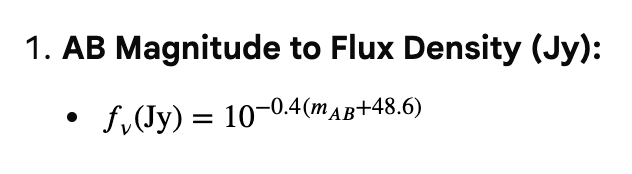

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = ax[0].imshow(current_image)
fig.colorbar(im, ax=ax[0], label="amp")
magab = amplitude_to_magnitude(
    current_image, mag_zero_point=mag_zero_points_30_seconds[band]
)
im = ax[1].imshow(magab, norm="linear")
fig.colorbar(im, ax=ax[1], label="mag")
fnu_jy = 1e-9 * 10 ** (-0.4 * (magab - 8.9))
im = ax[2].imshow(fnu_jy)
fig.colorbar(im, ax=ax[2], label="$f_{\\nu}$ (nJy)")
fig.tight_layout()

### Make a gif of difference images

In [ ]:
# Create a directory to store the frames
os.makedirs("frames", exist_ok=True)

# Generate and save the frames
frames = []
# Calculate the zscale limits for all images
for i in range(len(image_df.index) - 1):
    ind = image_df.index[i]
    next_ind = image_df.index[i + 1]
    # coadd minus exposure
    diff_image = (
        image_df.loc[:next_ind, "image_array"].mean()
        - image_df.loc[next_ind, "image_array"]
    )
    # diff image from two exposure
    # science_image = image_df.loc[ind, 'image_array']
    # band1 = image_df.loc[ind, 'band']
    band2 = image_df.loc[next_ind, "band"]
    obs_time1 = np.round(image_df.loc[ind, "obs_time"], 2)
    obs_time2 = np.round(image_df.loc[next_ind, "obs_time"], 2)
    # Set consistent vmin and vmax for all diff_image
    plt.imshow(diff_image, vmin=-200, vmax=200, origin="lower", cmap="viridis")
    plt.title(
        f"Year{(obs_time2//365)+1}\n Band {band2}: Day {obs_time2}-past observations"
    )
    plt.colorbar()
    frame_path = f"frames/frame_{ind}.png"
    plt.savefig(frame_path)
    plt.close()
    frames.append(Image.open(frame_path))

# Save the frames as a gif
gif_path = "quad_lens_series_diff_linear_current_all_past.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=200,
    loop=0,
)

# Clean up the frames directory
for frame in frames:
    os.remove(frame.filename)
os.rmdir("frames")
# plt.imshow(image_lens_series_all[1]-image_lens_series_all[0], origin='lower')
# plt.colorbar()

### View science image strips in all bands

In [ ]:
# Get a point source coordinate so that you can plot these image center in the plot.
image_number = lens_class.image_number
if isinstance(image_number, list):
    image_number = image_number[
        0
    ]  ### taking the number of images from the first plane source
fig, ax = plt.subplots(1, image_number, figsize=(30, 7))
ax = ax.flatten()
colors = ["red", "green", "orange", "blue"]
for band in list("grizy"):
    time_sampled = np.array(
        observation_dates[band]
    )  # we're picking the dates that we expect to observe with Rubin
    # loop through the bands and plot the light curves
    for i in range(image_number):
        ax[i].plot(
            time,
            lens_class.point_source_magnitude(band=band, lensed=True, time=time)[0][i],
            label=f"{band}-band, image-{i+1}",
            alpha=0.2,
        )
        ax[i].scatter(
            time_sampled,
            lens_class.point_source_magnitude(
                band=band, lensed=True, time=time_sampled
            )[0][i],
            marker="*",
            s=100,
            color=colors[i],
        )

ax[0].set_ylabel("Magnitude")
fig.supxlabel("Time" "[Days]")
for a in ax:
    a.invert_yaxis()
    a.legend()
fig.suptitle(
    f"Light curves for {lens_class.image_number} images of a multiply-imaged quasar"
)
fig.tight_layout()

# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])

# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "../../tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[delta_pix, 0], [0, delta_pix]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]

# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.


# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
for band in list("grizy"):
    time_sampled = observation_dates[band]
    repeats = len(time_sampled)
    psf_kernels_all = psf_kernel_list * repeats
    transform_matrix_all = transform_matrix_list * repeats
    mag_list = [mag_zero_points_30_seconds[band]]
    mag_zero_points_all = mag_list * repeats
    # mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

    expo_list = [exp_time]
    exposure_time_all = expo_list * repeats
    image_lens_series_all = lens_image_series(
        lens_class=lens_class,
        band=band,
        mag_zero_point=mag_zero_points_all,
        num_pix=num_pix,
        psf_kernel=psf_kernels_all,
        transform_pix2angle=transform_matrix_all,
        exposure_time=exposure_time_all,
        std_gaussian_noise=None,
        t_obs=time,
        with_deflector=False,
        with_ps=True,
        with_source=True,
        add_noise=True,
    )
    pix_coord = pix_coord_dict[band]["image_pix"]  # band r

    plot_montage = create_image_montage_from_image_list(
        num_rows=1,
        num_cols=10,
        images=image_lens_series_all,
        time=time_sampled,
        image_center=pix_coord,
    )
    plot_montage.suptitle(f"{band}-band; Lens Light Subtracted", y=1.01)

In [ ]:
pix_coord_list

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="i", lensed=True, time=time)[0][0],
    label="i-band, image-1",
)
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="r", lensed=True, time=time)[0][0],
    label="r-band, image-1",
)
ax1.plot(
    time,
    lens_class.point_source_magnitude(band="g", lensed=True, time=time)[0][0],
    label="g-band, image-1",
)
# ax1.gca().invert_yaxis()
ax1.set_ylabel("Magnitude")
ax1.set_xlabel("Time" "[Days]")
# ax1.set_xlim(0, 500)
# ax1.set_ylim(19.5, 21.25)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="i", lensed=True, time=time)[0][1],
    label="i-band, image-2",
)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="r", lensed=True, time=time)[0][1],
    label="r-band, image-2",
)
ax2.plot(
    time,
    lens_class.point_source_magnitude(band="g", lensed=True, time=time)[0][1],
    label="g-band, image-2",
)
# ax1.gca().invert_yaxis()
ax2.set_ylabel("Magnitude")
ax2.set_xlabel("Time" "[Days]")
# ax2.set_xlim(0, 250)
# ax2.set_ylim(None, 25)
ax2.invert_yaxis()
ax1.invert_yaxis()
ax1.legend()
ax2.legend()

## Set observation time and image configuration

In [ ]:
time = np.linspace(0, 250, 10)
# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])
repeats = len(time)
# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "../tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats
# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.
transform_matrix_all = transform_matrix_list * repeats

# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats
# mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

expo_list = [30]
exposure_time_all = expo_list * repeats

## Simulate Image

In [ ]:
# Simulate a lens image
image_lens_series_i = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_g = lens_image_series(
    lens_class=lens_class,
    band="g",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)
image_lens_series_r = lens_image_series(
    lens_class=lens_class,
    band="r",
    mag_zero_point=mag_zero_points_all,
    num_pix=64,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)

In [ ]:
rgb_image_list = []
for i in range(len(image_lens_series_i)):
    rgb_image_list.append(
        rgb_image_from_image_list(
            image_list=[
                image_lens_series_i[i],
                image_lens_series_r[i],
                image_lens_series_g[i],
            ],
            stretch=0.5,
        )
    )

## Visualize simulated images

In [ ]:
plot_montage = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=rgb_image_list, time=time, image_center=pix_coord
)

### Graveyard

In [ ]:
# image_lens_series_lens_only = lens_image_series(
#     lens_class=lens_class,
#     band="i",
#     mag_zero_point=mag_zero_points_all,
#     num_pix=num_pix,
#     psf_kernel=[None] * repeats,
#     transform_pix2angle=transform_matrix_all,
#     exposure_time=exposure_time_all,
#     std_gaussian_noise=None,
#     t_obs=time,
#     with_deflector=True,
#     with_ps=False,
#     with_source=False,
#     add_noise=False,
# )
# image_lens_series_ps_only = lens_image_series(
#     lens_class=lens_class,
#     band="i",
#     mag_zero_point=mag_zero_points_all,
#     num_pix=num_pix,
#     psf_kernel=[None] * repeats,
#     transform_pix2angle=transform_matrix_all,
#     exposure_time=exposure_time_all,
#     std_gaussian_noise=None,
#     t_obs=time,
#     with_deflector=False,
#     with_ps=True,
#     with_source=False,
#     add_noise=False,
# )
# image_lens_series_src_only = lens_image_series(
#     lens_class=lens_class,
#     band="i",
#     mag_zero_point=mag_zero_points_all,
#     num_pix=num_pix,
#     psf_kernel=[None] * repeats,
#     transform_pix2angle=transform_matrix_all,
#     exposure_time=exposure_time_all,
#     std_gaussian_noise=None,
#     t_obs=time,
#     with_deflector=False,
#     with_ps=False,
#     with_source=True,
#     add_noise=False,
# )

In [ ]:
# plot_montage = create_image_montage_from_image_list(
#     num_rows=1,
#     num_cols=5,
#     images=image_lens_series_lens_only,
#     time=time_sampled,
#     image_center=pix_coord,
# )
# plot_montage.suptitle("Only Lens Light", y=1.01)

# plot_montage = create_image_montage_from_image_list(
#     num_rows=1,
#     num_cols=5,
#     images=image_lens_series_ps_only,
#     time=time_sampled,
#     image_center=pix_coord,
# )
# plot_montage.suptitle("Lens Light Subtracted", y=1.01)

# plot_montage = create_image_montage_from_image_list(
#     num_rows=1,
#     num_cols=5,
#     images=image_lens_series_src_only,
#     time=time_sampled,
#     image_center=pix_coord,
# )
# plot_montage.suptitle("Lens and AGN Light Subtracted", y=1.01)